In [1]:
import numpy as np
import os, h5py

from utils import plot_data, return_best_chi2dof, plot_ref_data, BuildSample_DY, normalize, candidate_sigma


from matplotlib import pyplot as plt

from tests import fused_p, fused_t, min_p, avg_p, Zscore, fusion, p_to_z, emp_pvalues, emp_pvalue, bootstrap_pval, power

## normalization and kernel width

In [3]:
cut_mll = 60
cut_pt = 20
cut_eta = 2.4

In [23]:
# feature order ['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']s
all_ref = BuildSample_DY(N_Events=100000000, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=1234))

mask_idx_1 = np.where((all_ref[:, 4] <= cut_pt) | (all_ref[:, 5] <= cut_pt) | (np.abs(all_ref[:, 1]) > cut_eta) | (np.abs(all_ref[:, 2]) > cut_eta) | (all_ref[:, 3] <= cut_mll))[0]
masked_all_ref = np.delete(all_ref, mask_idx_1, axis=0)

mean_R = np.mean(masked_all_ref, axis=0)
std_R  = np.std(masked_all_ref, axis=0)

print(mean_R)
print(std_R)

DiLepton_SM


(3735456, 6)
[3.05212537e+00 4.59876795e-04 3.66978211e-04 9.11198636e+01
 4.67488118e+01 3.60544255e+01]
[ 0.52342366  1.24487457  1.25051629 12.79724998 15.86122412  8.95046637]


In [29]:
# feature order ['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']
ref_sample = BuildSample_DY(N_Events=20000, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=0))
mask_idx_2 = np.where((ref_sample[:, 4] <= cut_pt) | (ref_sample[:, 5] <= cut_pt) | (np.abs(ref_sample[:, 1]) > cut_eta) | (np.abs(ref_sample[:, 2]) > cut_eta) | (ref_sample[:, 3] <= cut_mll))[0]
masked_ref_sample = np.delete(ref_sample, mask_idx_2, axis=0)

norm_masked_ref_sample = normalize(masked_ref_sample[:,[0,1,2,4,5]],np.delete(mean_R, 3),np.delete(std_R, 3))

for perc in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"{perc}%: {candidate_sigma(norm_masked_ref_sample, perc=perc)}")

DiLepton_SM
(20000, 6)
1: 0.316
5: 0.571
10: 0.766
25: 1.19
50: 1.787
75: 2.489
90: 3.175
95: 3.568
99: 4.226


## nplm-fuse

In [2]:
ref_folder = "/home/marcol/mletizia-multiple-testing-nplm/output_5d/Ntoys1000_NR100000_NB20000_cut60_null"
data_folder = "/home/marcol/mletizia-multiple-testing-nplm/output_5d/Ntoys300_NR100000_NB20000_NS20_Z300_cut60/"

In [4]:
#[0.31,0.76,1.77,3.15,4.21] 1,10,50,90,99 percentiles
ref = np.load(ref_folder+"/t_array.npy")
data = np.load(data_folder+"/t_array.npy")

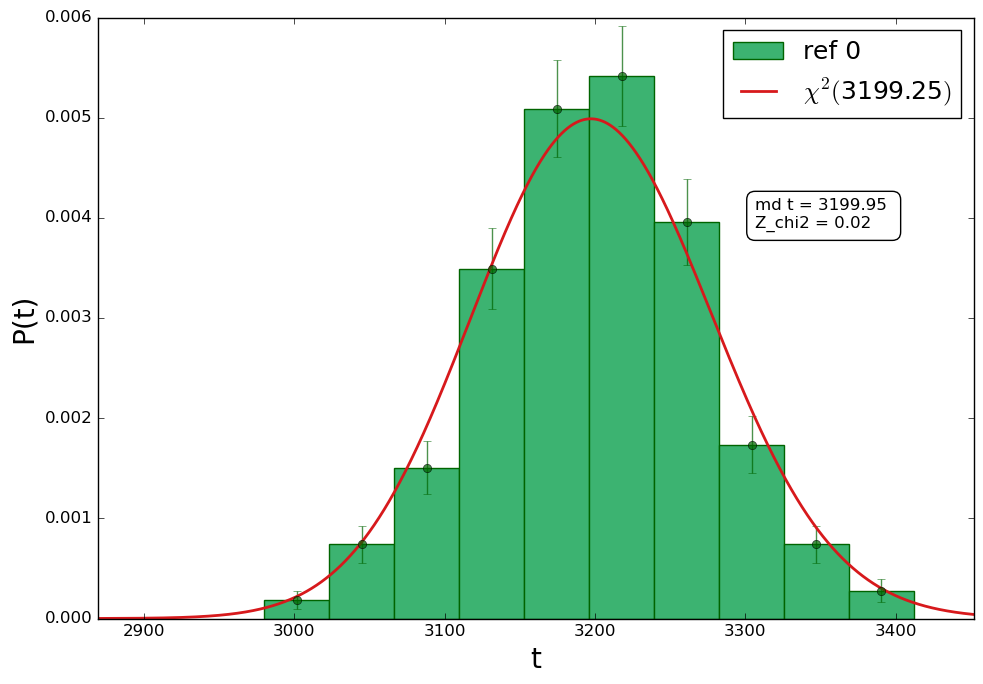

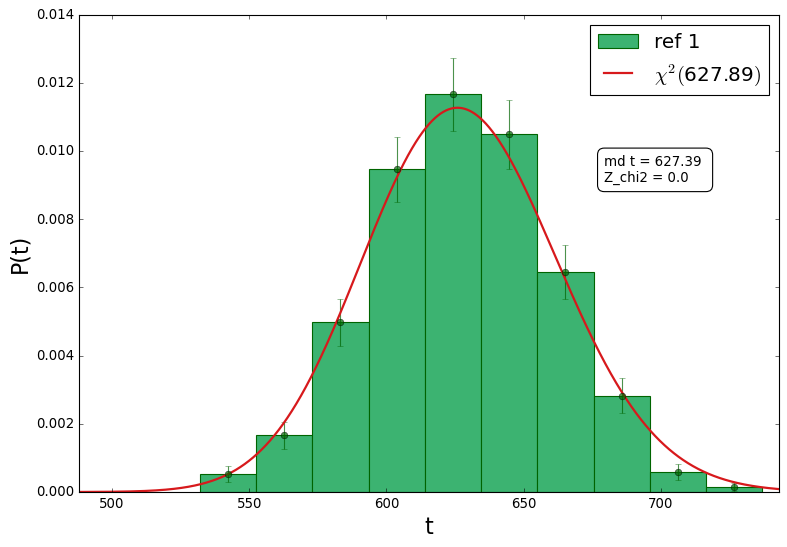

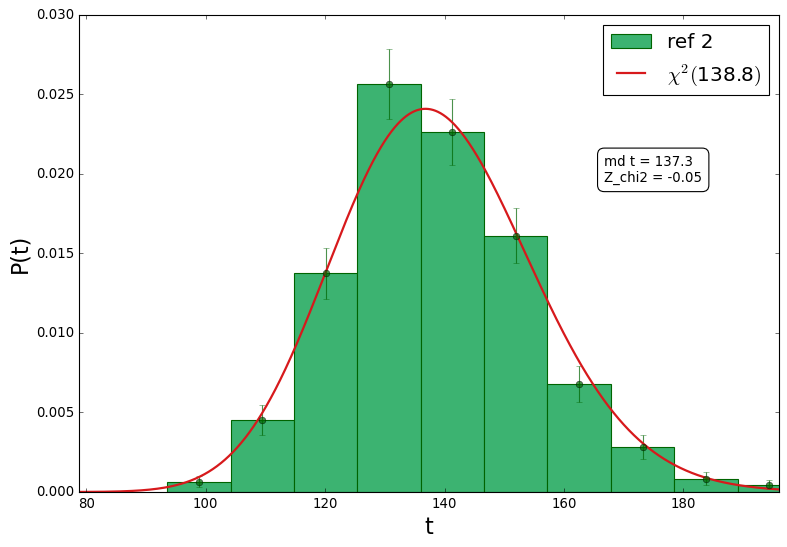

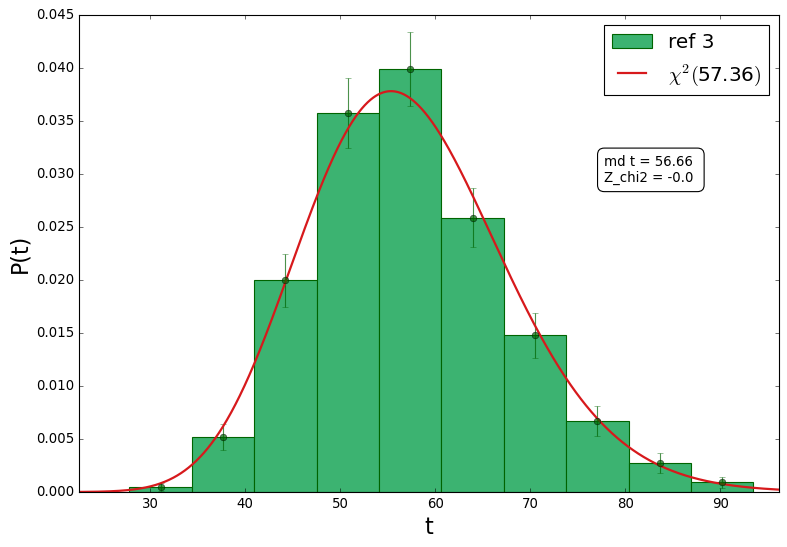

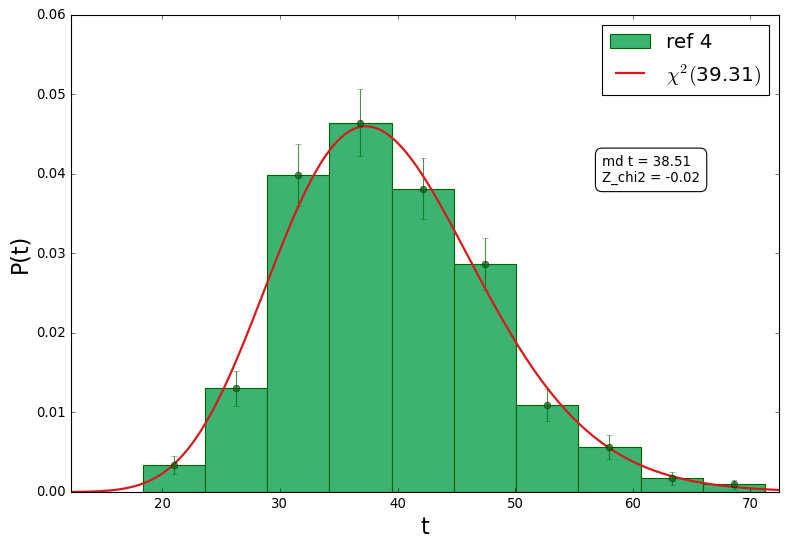

In [6]:
# check null distributions and chi2
for i in np.arange(ref.shape[1]):
    plot_data(ref[:,i], label=f'ref {i}', dof=round(return_best_chi2dof(ref[:,i])[0],2))

In [8]:
for i in range(ref.shape[1]):
    print(np.median(Zscore(ref[:,i],data[:,i])))

0.06515334529401406
0.461617945500972
0.9391527045817105
0.8786019348016423
0.817603625802594


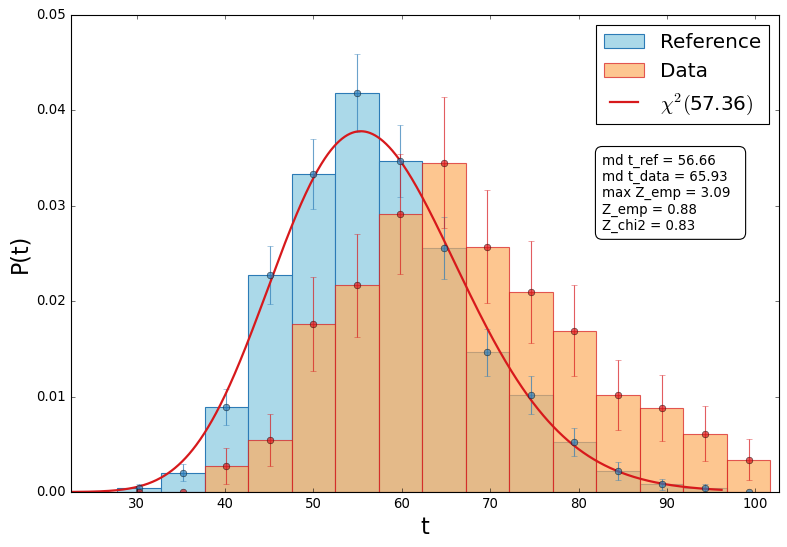

In [9]:
plot_ref_data(ref[:,-2],data[:,-2],bins=15,dof=round(return_best_chi2dof(ref[:10000,-2])[0],2))

In [10]:
for T in [0.001, 1, 10, 1000, 1e5, 1e10]:
    print(np.median(p_to_z((fused_t(ref,data,T)))))

0.06515334529401406
0.06515334529401406
0.06515334529401406
0.12175013936667117
0.4868377956997456
0.5024042508467157


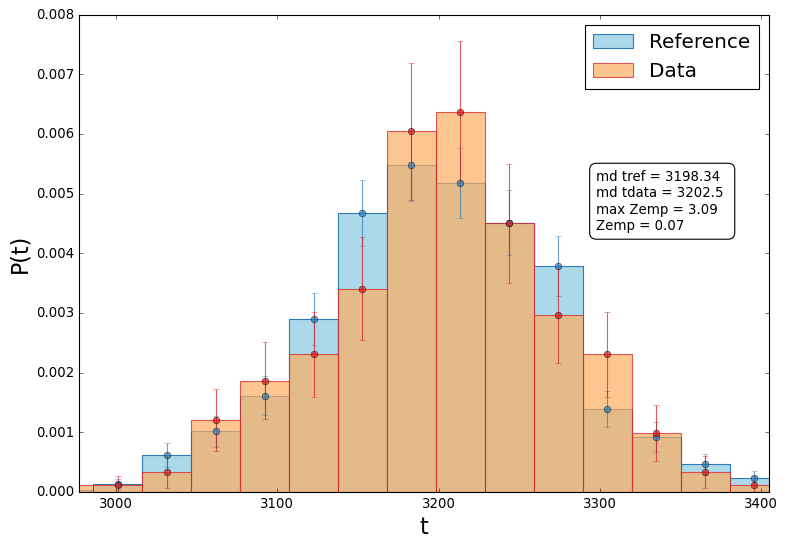

In [11]:
plot_ref_data(fusion(ref,1),fusion(data,1),bins=15)

In [12]:
pmin_ref, pmin_data =  min_p(ref,data,rng=None)
np.abs(np.median(Zscore(pmin_ref,pmin_data)))

0.7763159841883368

In [13]:
bootstrap_minp = []
for i in range(20):
    pmin_ref, pmin_data =  min_p(ref,data,rng=i)
    bootstrap_minp.append(np.abs(np.median(Zscore(pmin_ref,pmin_data))))

print(np.mean(bootstrap_minp),
np.std(bootstrap_minp))

0.7689495168532574 0.04359552416672915


In [14]:
pvals_min_p_ref = []
for idx, el in enumerate(np.transpose(pmin_ref)):
        pvals_min_p_ref.append(bootstrap_pval(np.delete(pmin_ref,idx),el))
#pvals_ref_min = [bootstrap_pval(np.delete(col,idx),el) for el in col]
        
pvals_min_p_data = emp_pvalues(pmin_ref,pmin_data)

In [15]:
np.max(pvals_min_p_ref)

1.0

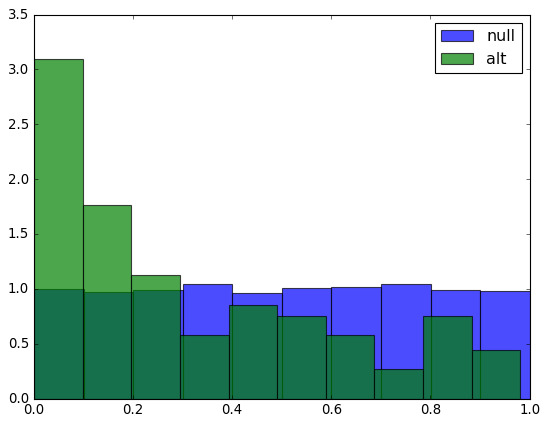

In [16]:
plt.hist(pvals_min_p_ref,bins=10,density=True, alpha=0.7,  label='null')
plt.hist(pvals_min_p_data,bins=10,density=True, alpha=0.7, label='alt')
plt.legend(loc=0)
plt.show()

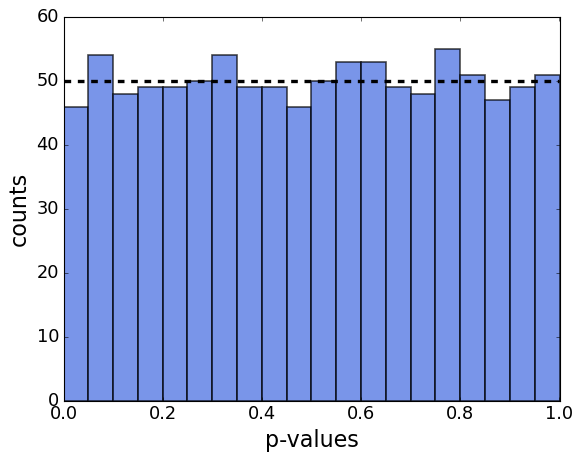

In [17]:
bins=np.linspace(0,1,21)
plt.hist(pvals_min_p_ref,bins=bins, density=False, color='royalblue', alpha=0.7, lw=1.5)#,  label='Null')
#plt.hist(pvals_min_p_data,bins=bins, density=False, histtype='step', edgecolor='k', hatch='/', lw=1.5, fill=False, label='Alternative')
plt.hlines(50, 0, 1, colors='k', linestyles='--', lw=3)
plt.xlabel("p-values", fontsize=20)
plt.ylabel("counts", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim((0.5,1.5))
#plt.legend(loc=0, fontsize=20)
plt.show()

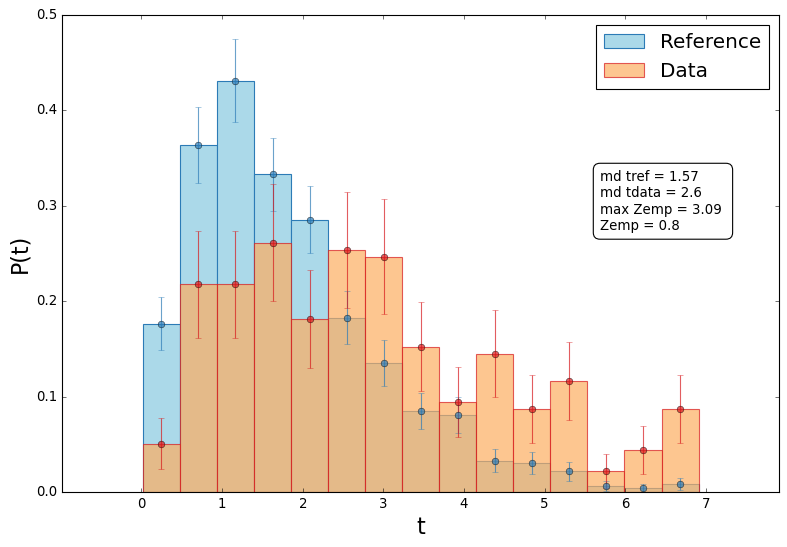

In [18]:
plot_ref_data(pmin_ref,pmin_data,bins=15)

In [19]:
for T in [1e-3, 0.1, 1, 100, 1000]:
    fused_p_ref, fused_p_data = fused_p(ref,data,T)
    print(np.abs(np.median(Zscore(fused_p_ref,fused_p_data))))

0.7462035639623255
0.8990415558801084
0.906608273398763
0.8334539385623453
0.833443470361675


In [20]:
bootstrap_fusedp1 = []
for i in range(20):
    fused_p_ref, fused_p_data = fused_p(ref,data,T=1,rng=i)
    bootstrap_fusedp1.append(np.median(Zscore(fused_p_ref,fused_p_data)))

print(np.mean(bootstrap_fusedp1),
np.std(bootstrap_fusedp1))

0.8971045177930275 0.03505226912741694


In [21]:
pvals_fused_p_ref = []
for idx, el in enumerate(np.transpose(fused_p_ref)):
        pvals_fused_p_ref.append(bootstrap_pval(np.delete(fused_p_ref,idx),el))
pvals_fused_p_ref = np.array(pvals_fused_p_ref)
pvals_fused_p_ref[pvals_fused_p_ref==0.]=0.001
pvals_fused_p_ref = -np.log(pvals_fused_p_ref)

In [22]:
np.count_nonzero(pvals_fused_p_ref)

999

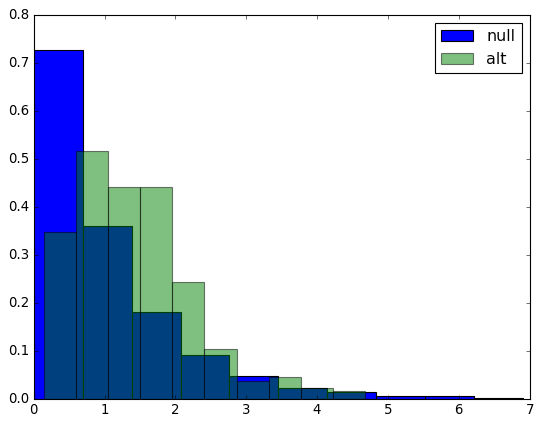

In [23]:
plt.hist(pvals_fused_p_ref,bins=10,density=True, label='null')
plt.hist(fused_p_data,bins=10,density=True, alpha=0.5, label='alt')
plt.legend(loc=0)
plt.show()

In [24]:
fused_p_ref, fused_p_data = fused_p(ref,data)
print(
    power(fusion(ref,1),fusion(data,1))[1],
    power(pmin_ref,pmin_data)[1],
    power(fused_p_ref,fused_p_data)[1],
    )

[0.31561462 0.1627907  0.01993355 0.00664452] [0.59468439 0.43189369 0.15614618 0.0730897 ] [0.61129568 0.46511628 0.11295681 0.05647841]


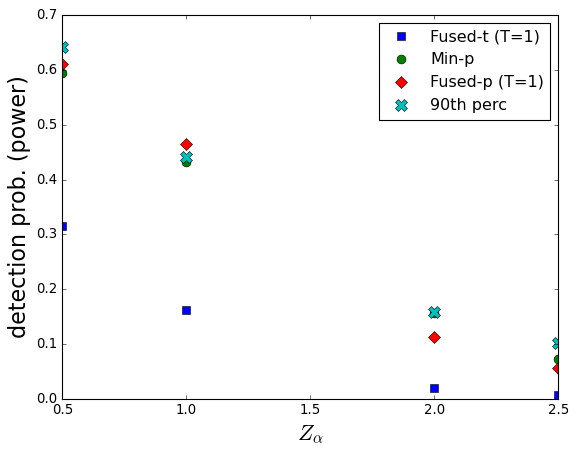

In [25]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

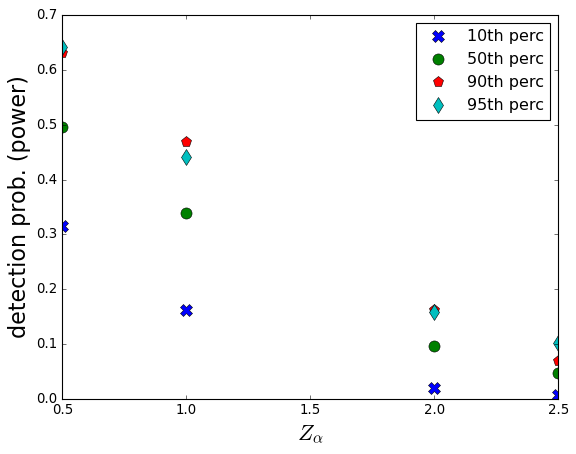

In [26]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label='10th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,1],data[:,1])[1],label='50th perc',linestyle='None',marker='o',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,2],data[:,2])[1],label='90th perc',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,3],data[:,3])[1],label='95th perc',linestyle='None',marker='d',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

## nplm-avg

In [27]:
ref_avg = np.load(ref_folder+"/t_avg_array.npy")
data_avg = np.load(data_folder+"/t_avg_array.npy")

ref_avg_exp = np.load(ref_folder+"/t_avg_exp_array.npy")
data_avg_exp = np.load(data_folder+"/t_avg_exp_array.npy")

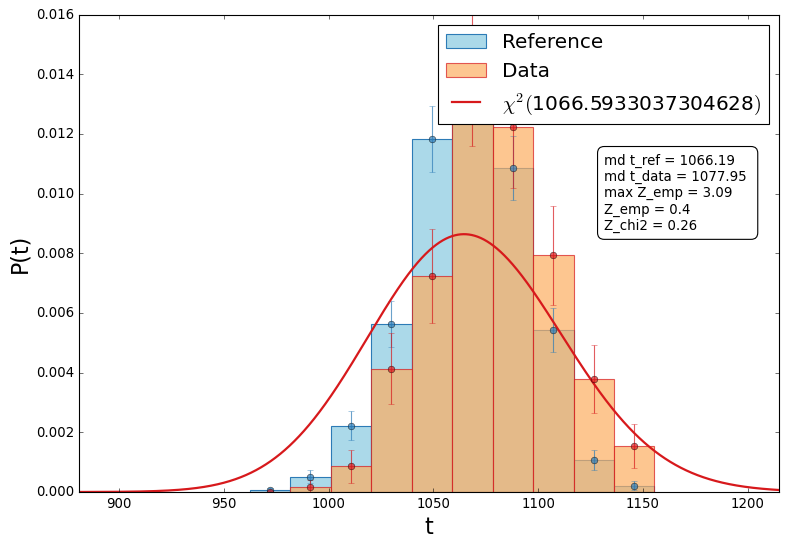

In [28]:
plot_ref_data(ref_avg,data_avg,dof=return_best_chi2dof(ref_avg)[0])

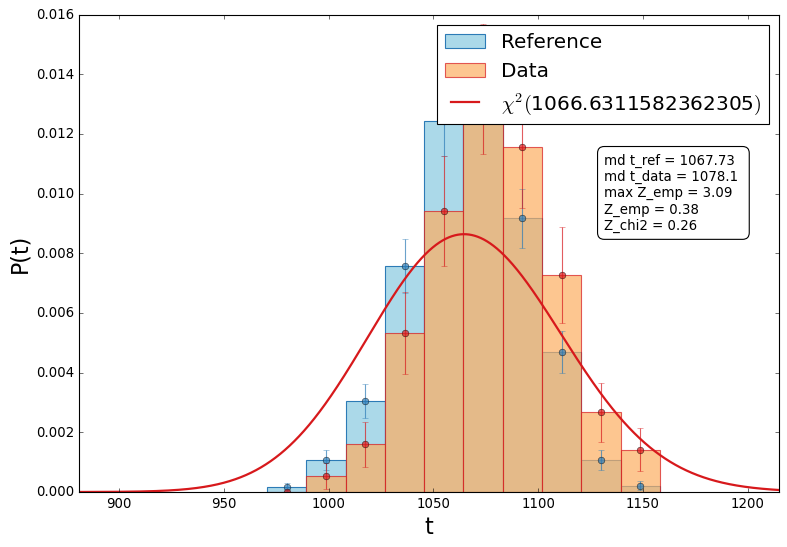

In [29]:
plot_ref_data(ref_avg_exp,data_avg_exp,dof=return_best_chi2dof(ref_avg_exp[:50000])[0])

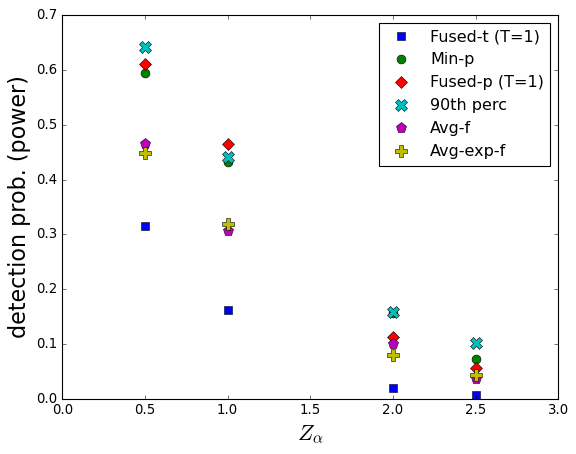

In [32]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg,data_avg)[1],label='Avg-f',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg_exp,data_avg_exp)[1],label='Avg-exp-f',linestyle='None',marker='P',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.xlim(0,3)
plt.show()

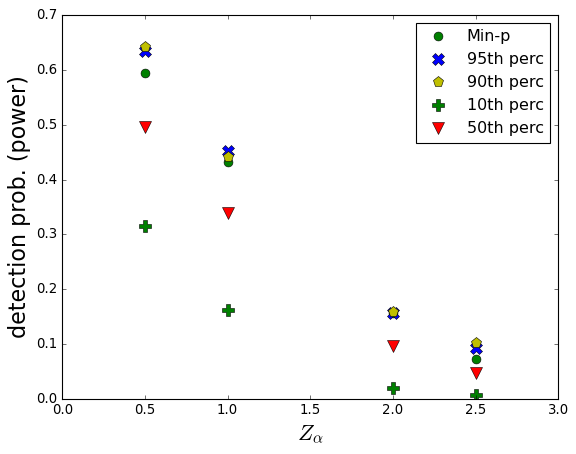

In [34]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8, color='g')
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-1],data[:,-1])[1],label='95th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='p',ms=10,c='y')
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label='10th perc',linestyle='None',marker='P',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,1],data[:,1])[1],label='50th perc',linestyle='None',marker='v',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.xlim(0,3)
plt.show()